# Convolutional Neural Network for Classification of Breast Cancer Cells

### **Authors**: Aaron Cherry

## Overview

The purpose of this study is to train a Convolutional Neural Network to identify and classify cancerous cells in H&E-stained needle biopsy images. The aim is to deploy a web application that functions to analyze user provided images and give confidence metrics regarding the presence of cancerous tissues in the image.

## Business Problem

> Around the world, breast cancer annually affects about 1.7 million women. Compared to other
types of cancer, it is the highest recurrent cause of death. Based on collected data by the American
Cancer Society, approximately 268,600 new cases were diagnosed as invasive breast cancer patients
in 2019. In the same year, there were approximately 62,930 new cases of in-situ breast cancer identified,
with roughly 41,760 expected death cases due to breast cancer. Early diagnosis of breast cancer is
significant as a means to boost the number of survivors. The high cost of breast cancer diagnosis and
high morbidity have motivated researchers to explore solutions to develop more precise models for
cancer diagnosis.
~ Alzubaidi et. al. electronics

Invasive Ductal Carcinoma is one of the most common types of breast cancer.

They go on to explain that the screening and testing process for breast cancer is a long and expensive one. A process that can be augmented, facilitated, and made more cost effective by the introduction of Machine Learning and deep neural network models. The impaortance of machine learning models is reflected in the types of models built and the teams working on the issue such a Google, MIT, and international cooperative efforts like this one. But, to get an idea of how the models are trained on the data we have to get an idea of what the data set looks like and most importantly, the classes of cancer needed to be identified.

Multiple models have been tested to solve the specific problem of identifying cancerous cells in stained biopsy images. These models include [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [GoogleNet](https://towardsdatascience.com/deep-learning-googlenet-explained-de8861c82765), [ResNet](https://arxiv.org/abs/1512.03385), and [DenseNet](https://arxiv.org/abs/1608.06993). Although there have been many different effort in research on this specific problem, there are still barriers to deploying working modles in the field. 

## Data Understanding

The data used in this study comes from Kaggle and can be found [here](https://www.kaggle.com/paultimothymooney/breast-histopathology-images). The data consisits of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. The images were then split into 50x50 pixel patches giving 277,524 patches in total. The patches are classified as '0' for IDC-negative and '1' for IDC-positive.

> Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.
~ Kaggle Source

Histopathology is the study of the signs of the disease using the microscopic examination of a biopsy or surgical specimen that is processed and fixed onto glass slides. To visualize different components of the tissue under a microscope, the sections are dyed with one or more stains.

In [1]:
!pip install opencv-python

### Loading in the full data set with glob library

In [3]:
#Loading in applicable libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os, shutil
from glob import glob
import cv2

print(os.listdir("./data"))

['breast', 'dataset-master', 'dataset2-master', 'Documents - Shortcut.lnk', 'histo', 'IDC_regular_ps50_idx5', 'negative', 'positive', 'Test', 'Train', 'Validate']


## Data Preperations

- Import the data
- Separate the data by label
- Make new directory system
- Store the data in the new folders

In [4]:
from glob import glob
data = glob('./data/IDC_regular_ps50_idx5/**/*.png', recursive=True)

In [41]:
int(os.path.basename(datum).split('_')[0])

9383

In [74]:
# Sampling the data set by whole slide
slide_numbers = np.arange(8863,9300)
new_data = []
for datum in data:
    if int(os.path.basename(datum).split('_')[0]) in slide_numbers:
        new_data.append(datum)


In [75]:
# Checking to see if all of the data is accounted for
len(data)

277524

In [76]:
len(new_data)

65628

In [77]:
# Separating the IDC-positive and IDC-negative images
class0 = []
class1 = []
for datum in new_data:
    if datum.endswith('class0.png'):
        class0.append((datum.replace(os.path.basename(datum),''),os.path.basename(datum)))
    else:
        class1.append((datum.replace(os.path.basename(datum),''),os.path.basename(datum)))

In [78]:
print("There are {} files marked as IDC-negative.".format(len(class0)))
print("There are {} files marked as IDC-positive.".format(len(class1)))


There are 50274 files marked as IDC-negative.
There are 15354 files marked as IDC-positive.


In [79]:
# Setting up the directory system for copying over files
data_dir = './data/IDC_regular_ps50_idx5/'
new_dir = './data/split/'


In [80]:
# Making the new split directory in the output
os.mkdir(new_dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: './data/split/'

In [49]:
train_folder = os.path.join(new_dir, 'train')
train_pos  = os.path.join(train_folder, 'positive')
train_neg = os.path.join(train_folder, 'negative')

test_folder = os.path.join(new_dir, 'test')
test_pos  = os.path.join(test_folder, 'positive')
test_neg = os.path.join(test_folder, 'negative')

val_folder = os.path.join(new_dir, 'validation')
val_pos  = os.path.join(val_folder, 'positive')
val_neg = os.path.join(val_folder, 'negative')

In [50]:
os.mkdir(test_folder)
os.mkdir(test_pos)
os.mkdir(test_neg)

os.mkdir(train_folder)
os.mkdir(train_pos)
os.mkdir(train_neg)

os.mkdir(val_folder)
os.mkdir(val_pos)
os.mkdir(val_neg)

### Splitting the IDC-Positive data into train,test,validation sets

|Set|% split|N-files|
|:------:|:--------:|:--------:|
|train|60|47277|
|validation|20|15752| 
|test|20|15757|


The following code will split the data and separate it accordingly in the new directory.

In [54]:
# train IDC-positive
imgs = class1[:int(np.round(len(class1)*0.6,0))]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(train_pos, img[1])
    shutil.copyfile(origin, destination)

In [55]:
# validation IDC-positive
imgs = class1[int(np.round(len(class1)*0.6,0)):int(np.round(len(class1)*0.8,0))]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(val_pos, img[1])
    shutil.copyfile(origin, destination)

In [56]:
# test IDC-positive
imgs = class1[int(np.round(len(class1)*0.8,0)):]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(test_pos, img[1])
    shutil.copyfile(origin, destination)



### Doing the same thing for the IDC-negative images 

|Set|% split|N-files|
|:------:|:--------:|:--------:|
|train|60|119,243|
|test|20|39,747|
|validation|20|39,748| 

The following code will split the data and separate it accordingly in the new directory.

In [57]:
# train IDC-negative
imgs = class0[:int(np.round(len(class0)*0.6,0))]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(train_neg, img[1])
    shutil.copyfile(origin, destination)

In [58]:
# test IDC-negative
imgs = class0[int(np.round(len(class0)*0.6,0)):int(np.round(len(class0)*0.8,0))]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(test_neg, img[1])
    shutil.copyfile(origin, destination)

In [59]:
# validation IDC-negative
imgs = class0[int(np.round(len(class0)*0.8,0)):]
for img in imgs:
    origin = os.path.join(img[0], img[1])
    destination = os.path.join(val_neg, img[1])
    shutil.copyfile(origin, destination)

Looking at the amount of data in each folder to make sure all of it is accounted for and that each set has the same ratio of neg/pos images.

In [81]:
print('There are', len(os.listdir(train_pos)), 'IDC-positive images in the training set.')
print('There are', len(os.listdir(train_neg)), 'IDC-negative images in the training set.\n')

print('There are', len(os.listdir(val_pos)), 'IDC-positive images in the validation set.')
print('There are', len(os.listdir(val_neg)), 'IDC-negative images in the validation set.\n')

print('There are', len(os.listdir(test_pos)), 'IDC-positive images in the test set.')
print('There are', len(os.listdir(test_neg)), 'IDC-negative images in the test set.\n')

There are 11378 IDC-positive images in the training set.
There are 37306 IDC-negative images in the training set.

There are 3793 IDC-positive images in the validation set.
There are 12435 IDC-negative images in the validation set.

There are 3793 IDC-positive images in the test set.
There are 12436 IDC-negative images in the test set.



In [61]:
print('There are', len(os.listdir(train_neg))+len(os.listdir(train_pos)), 'IDC-negative images in the training set')
print('There are', len(os.listdir(val_neg))+len(os.listdir(val_pos)), 'IDC-negative images in the validation set')
print('There are', len(os.listdir(test_neg))+len(os.listdir(test_pos)), 'IDC-negative images in the test set')

There are 48684 IDC-negative images in the training set
There are 16228 IDC-negative images in the validation set
There are 16229 IDC-negative images in the test set


## Exploritory Data Analysis

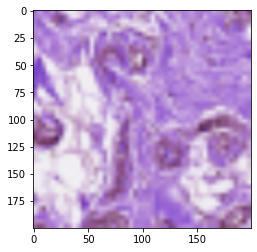

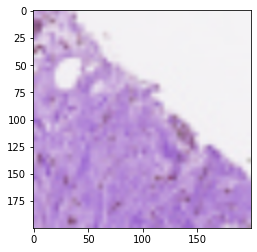

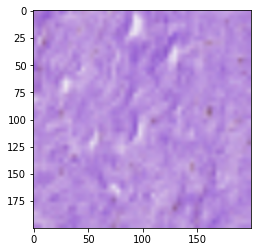

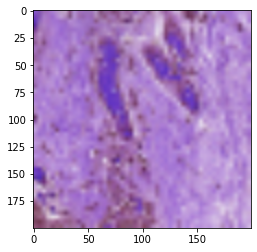

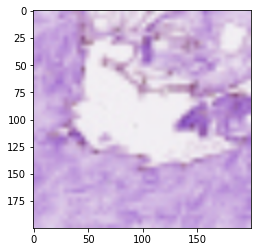

In [18]:
import cv2
# Look as a sample of the images to get an idea of what the cells look like
# TODO: give an examples of images with and without cancer cells and label them

for i in class0[:5]:
    img = cv2.imread(os.path.join(i[0],i[1]))
    img_1 = cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

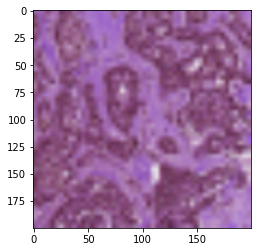

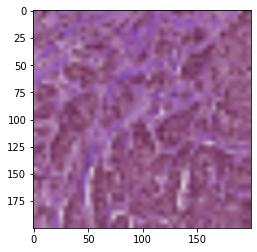

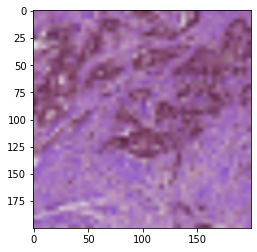

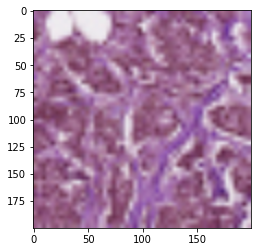

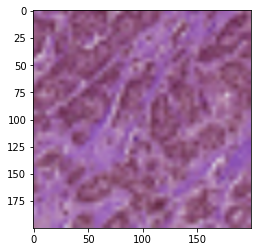

In [19]:
for i in class1[:5]:
    img = cv2.imread(os.path.join(i[0],i[1]))
    img_1 = cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

Some of the images are of the edge of the tissue with quite a bit of white space, this might throw off the model training and predictions but for now we'll keep these images in as most whole slide images will have these regions.

<ipython-input-34-f6eb0d40e803>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['IDC+','IDC-'],size=20)
<ipython-input-34-f6eb0d40e803>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,200000,2500),size=20)


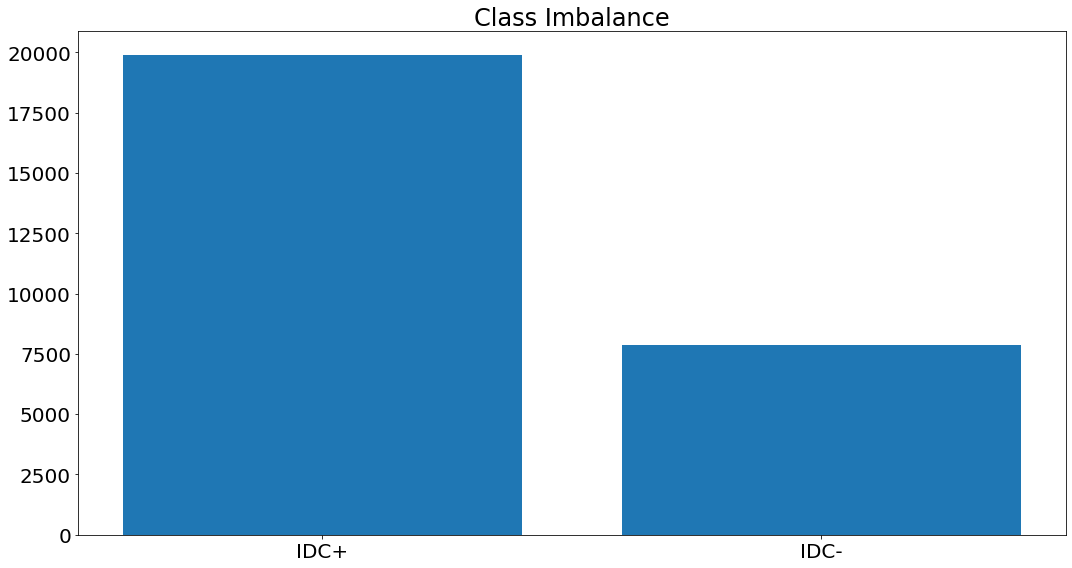

In [34]:

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(['IDC+','IDC-'],[len(class0),len(class1)])
ax.set_xticklabels(['IDC+','IDC-'],size=20)
ax.set_yticklabels(np.arange(0,200000,2500),size=20)
ax.set_title("Class Imbalance",size=24)
fig.tight_layout()
fig.savefig('./images/class_imbalance.png')

### Looking at the pixel distributions.

In [83]:
neg_red = []
pos_red = []
neg_green = []
pos_green = []
neg_blue = []
pos_blue = []
pos_bright = []
neg_bright = []

for i in random.sample(range(10000),1000):
    img = cv2.imread(os.path.join(class1[i][0],class1[i][1]))
    pos_red.extend(img[:,:,0].flatten().tolist())
    pos_green.extend(img[:,:,1].flatten().tolist())
    pos_blue.extend(img[:,:,2].flatten().tolist())
    pos_bright.extend(img.mean(axis=2).flatten().tolist())
    img2 = cv2.imread(os.path.join(class0[i][0],class0[i][1]))
    neg_red.extend(img2[:,:,0].flatten().tolist())
    neg_green.extend(img2[:,:,1].flatten().tolist())
    neg_blue.extend(img2[:,:,2].flatten().tolist())
    neg_bright.extend(img2.mean(axis=2).flatten().tolist())

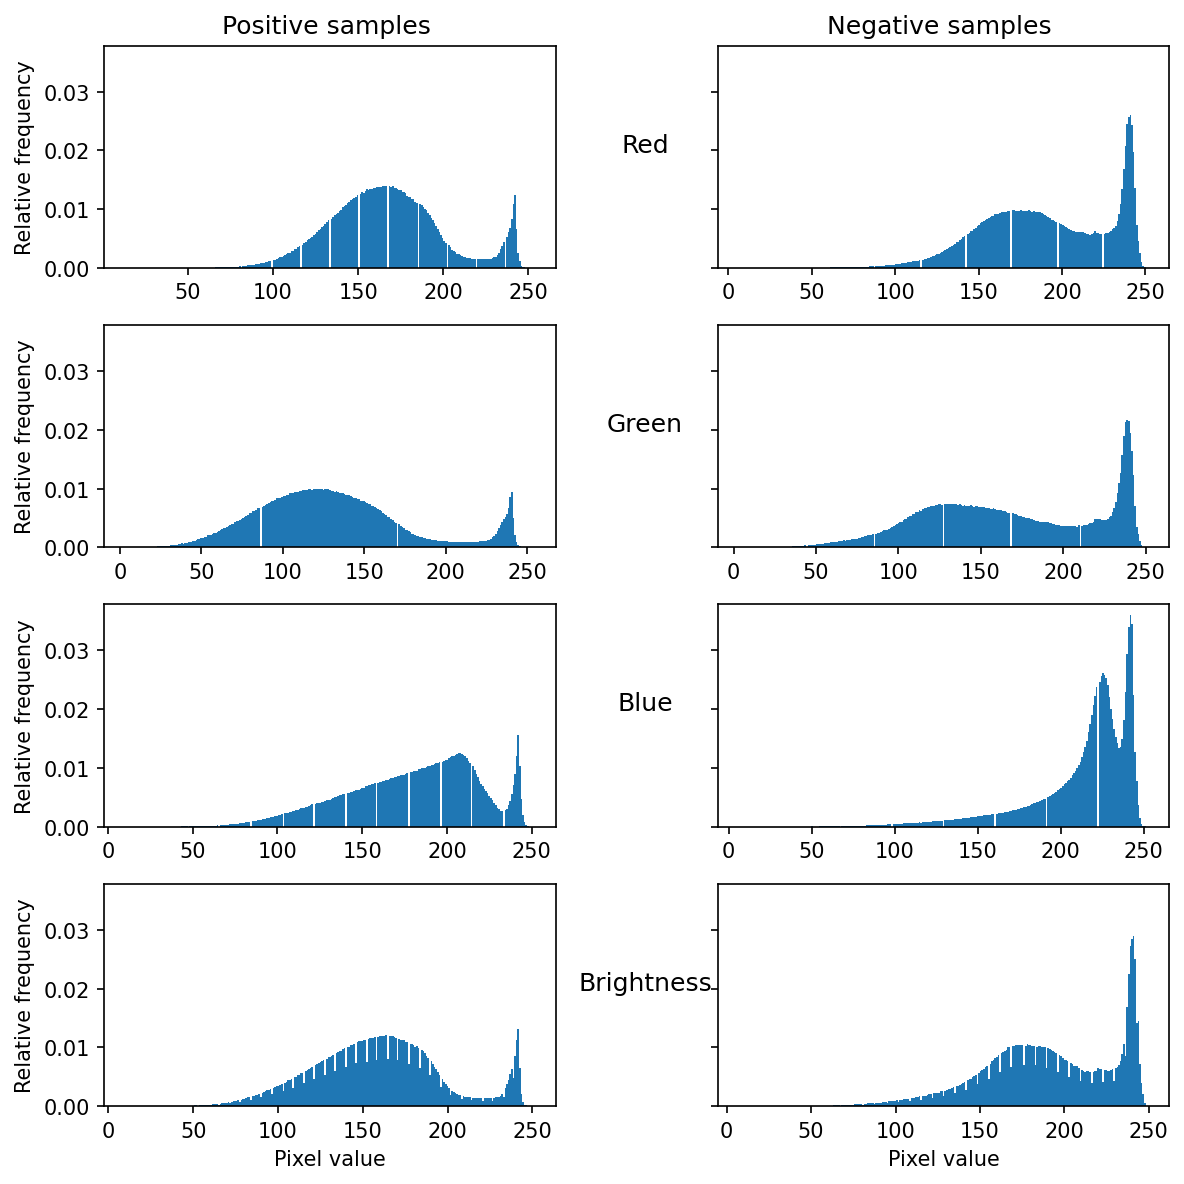

In [84]:
nr_of_bins = 255 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(pos_red,bins=nr_of_bins,density=True)
axs[0,1].hist(neg_red,bins=nr_of_bins,density=True)
axs[1,0].hist(pos_green,bins=nr_of_bins,density=True)
axs[1,1].hist(neg_green,bins=nr_of_bins,density=True)
axs[2,0].hist(pos_blue,bins=nr_of_bins,density=True)
axs[2,1].hist(neg_blue,bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(pos_bright,bins=nr_of_bins,density=True)
axs[3,1].hist(neg_bright,bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples ");
axs[0,1].set_title("Negative samples ");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("Brightness",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

## Modeling

In [53]:
# Importing all relevant packages for modeling in keras
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Import packages for showing the performance metrics
from sklearn.metrics import confusion_matrix

# Setting the random seed for reproducability
np.random.seed(123)

### Setting up the Image Data Flow

In [54]:
# set up batch generator for train set with 1000 as the batch size
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(100, 100), 
        batch_size = 32)

# set up batch generator for test set with 1000 as the batch size
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(100, 100), 
        batch_size = 32) 

# set up batch generator for validation set with 1000 as the batch size
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(100, 100), 
        batch_size = 32)


Found 166520 images belonging to 2 classes.
Found 55504 images belonging to 2 classes.
Found 55500 images belonging to 2 classes.


In [55]:
# Creating admin tools for the models like automatic saving checkpoints, early stopping routines, etc.
checkpoint = ModelCheckpoint("fsm.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=4,
                      verbose=1,
                      mode='auto')



### Functions for various models to try

In [174]:
def first_simple():
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(2, activation='sigmoid'))    
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    
    print(model.summary())
    return model
    
def modelEfficientNetB0():
    model = models.Sequential()
    model.add(EfficientNetB0(include_top = False, weights = "imagenet",
                            input_shape=(100,100, 3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2, activation = "sigmoid"))
    
    opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    
    print(model.summary())
    return model


## First Simple Model

In [175]:
# set the model as the first simple model
model = first_simple()

# Fit the model to the train data
history = model.fit(train_generator,
                    epochs=100,
#                     steps_per_epoch=100,
                    validation_data=val_generator,
                    callbacks=[checkpoint,early],
                    )#class_weight=weights


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 128)       

In [2]:
# Test results of the Model on train data 
loss_train,accuracy_train = model.evaluate(val_generator)
print('Model has an accuracy of {} with a loss of {} on the train subset.'.format(accuracy_train,loss_train ))

NameError: name 'model' is not defined

In [164]:
# Test results of the Model on test data
loss_test,accuracy_test = model.evaluate(test_generator)
print('Model has an accuracy of {} with a loss of {} on the test subset.'.format(accuracy_test,loss_test))

1735/1735 [==============================] - 25s 14ms/step - loss: 0.5844 - acc: 0.7264
Model has an accuracy of 0.7263801097869873 with a loss of 0.5844181776046753 on the test subset.


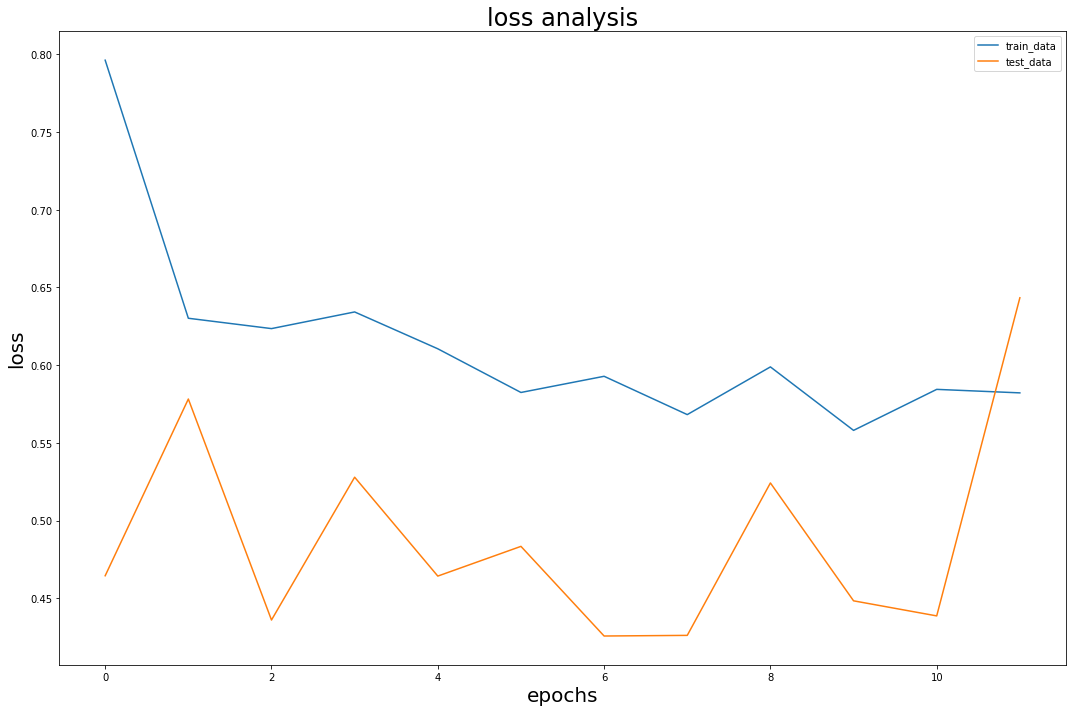

In [165]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epochs', size = 20)
ax.set_ylabel('loss', size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('loss analysis',size = 24)
plt.tight_layout()
fig.savefig('effNetB0_loss.png')

plt.show()

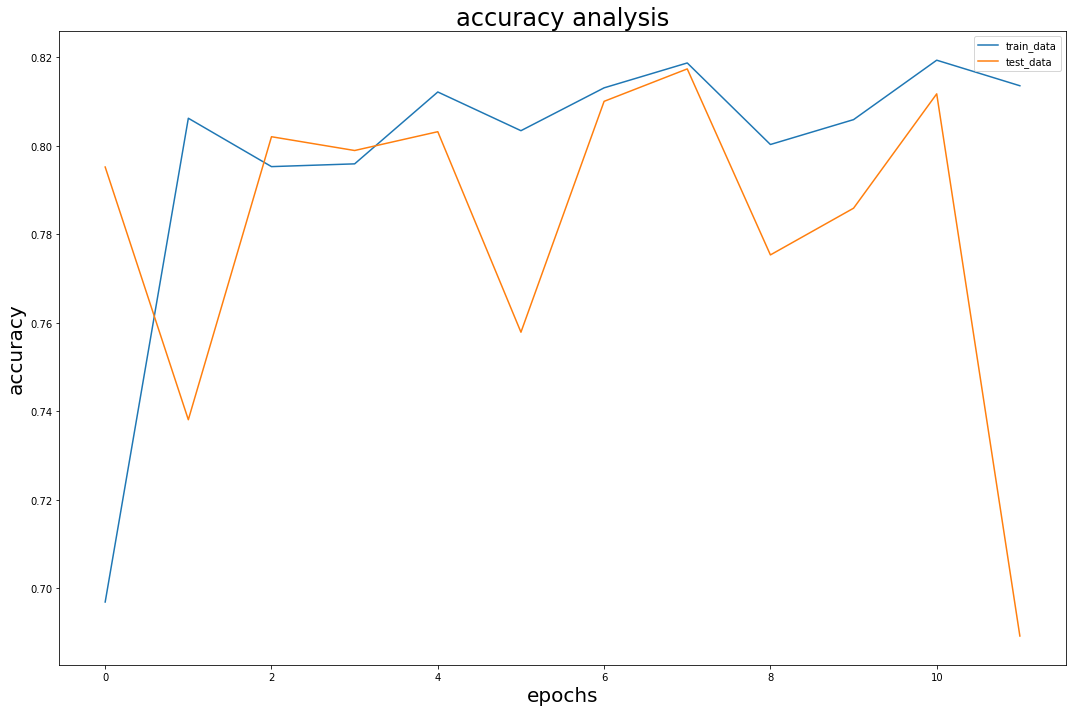

In [166]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_xlabel('epochs',size = 20)
ax.set_ylabel('accuracy',size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('accuracy analysis',size = 24)
plt.tight_layout()
fig.savefig('effNetB0_acc.png')
plt.show()

In [169]:
model.predict(test_generator)

array([[0.15581864, 0.83723956],
       [0.10082308, 0.8930737 ],
       [0.07699058, 0.9207874 ],
       ...,
       [0.5129179 , 0.49375516],
       [0.20288092, 0.794462  ],
       [0.87930673, 0.12254521]], dtype=float32)

In [170]:
y_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [171]:
y_predicts = np.argmin(model.predict(test_generator),axis=1)
y_labels  = test_generator.labels

In [172]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

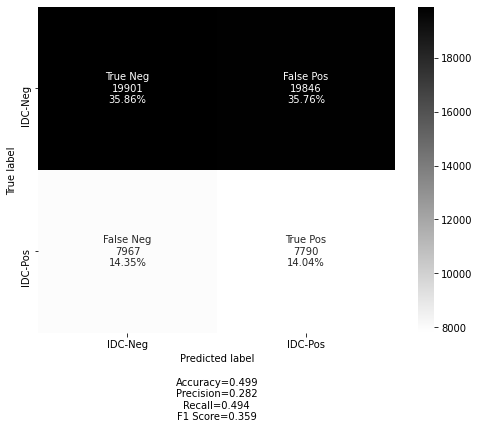

In [173]:
cf_matrix = confusion_matrix(y_labels,y_predicts)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['IDC-Neg', 'IDC-Pos']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary',
                      figsize=(8,6))

#### The Accuracy is lower than indicated in the modeling. The above metrics seem correct as the data has a large imballance in favor of IDC-negative. A model that would give a negative prediction would be correct about 66% of the time.

## First Iteration: Training with class weights

- to address the class imballance, I decidied to incorporate class weights within the model.
- i am also increasing the steps_per_epoch arg to include more of the data

In [158]:
# Creating admin tools for the models like automatic saving checkpoints, early stopping routines, etc.
checkpoint = ModelCheckpoint("denseNet201.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=4,
                      verbose=1,
                      mode='auto')
weights = {0:1,
           1:2}

In [159]:
from tensorflow.keras.applications import DenseNet201

def second_simple(backbone, lr=1e-3):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    opt = Adam(lr=lr)# beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    print(model.summary())
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(100,100,3)
)

In [160]:
# set the model as the first simple model
model2 = second_simple(resnet)

# Fit the model to the train data
history = model.fit(train_generator,
                    epochs = 20,
                    steps_per_epoch=10,
                    validation_data=val_generator,
                    callbacks=[checkpoint],
                    class_weight=weights)#

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 3, 3, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________
None
Epoch 1/20
10/10 [==============================] - 24s 3s/step - loss: 0.4118 - acc: 0.8687 - v

KeyboardInterrupt: 

## Evaluation

In [153]:
# Test results of the Model on test data
loss_test,accuracy_test = model2.evaluate(test_generator)
print('Model has an accuracy of {} with a loss of {} on the test subset.'.format(accuracy_test,loss_test))

1735/1735 [==============================] - 75s 40ms/step - loss: 0.8081 - acc: 0.5284
Model has an accuracy of 0.5259260535240173 with a loss of 0.8078410029411316 on the test subset.


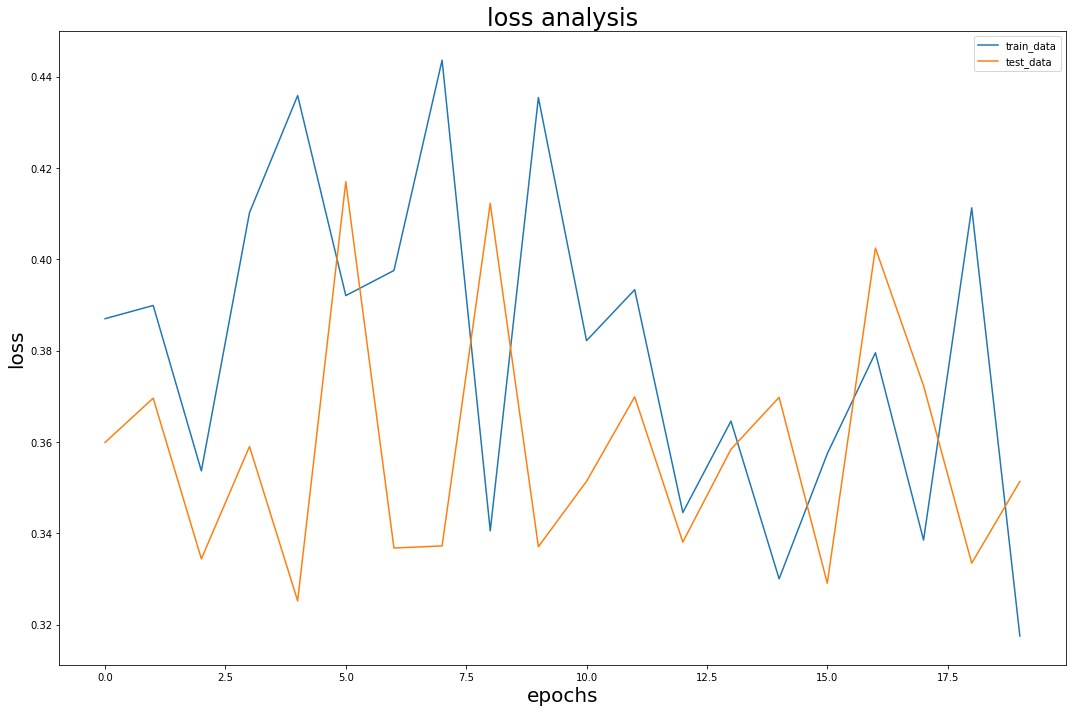

In [154]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epochs', size = 20)
ax.set_ylabel('loss', size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('loss analysis',size = 24)
plt.tight_layout()
fig.savefig('effNetB0_loss.png')

plt.show()

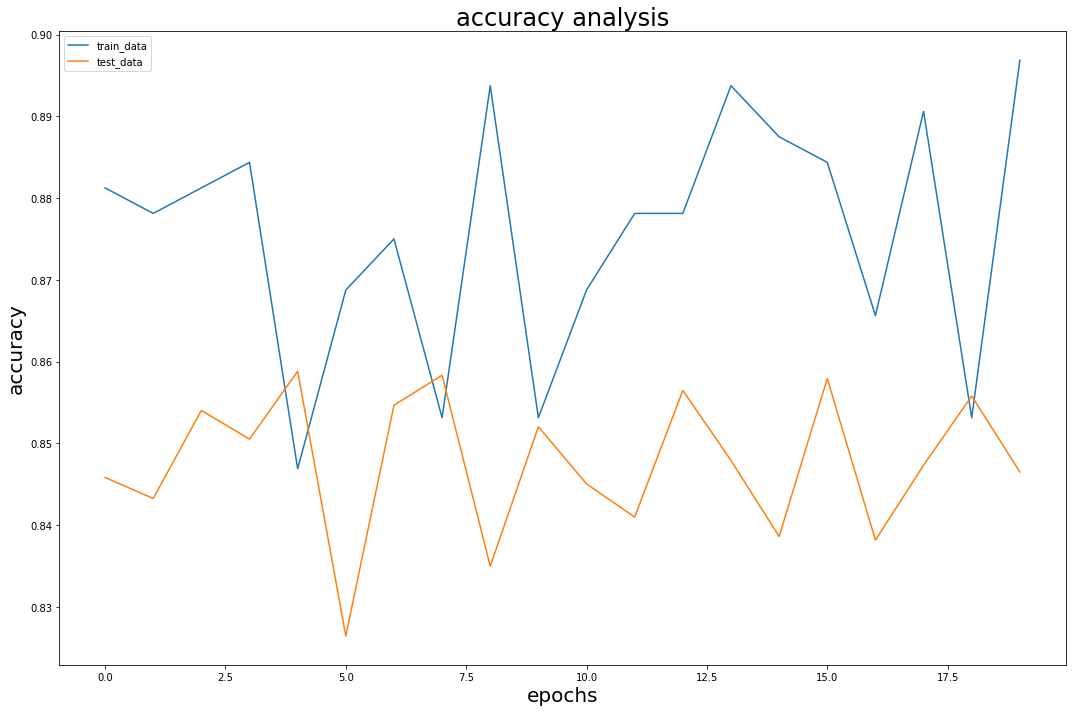

In [155]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_xlabel('epochs',size = 20)
ax.set_ylabel('accuracy',size = 20)
ax.legend(['train_data','test_data'])
ax.set_title('accuracy analysis',size = 24)
plt.tight_layout()
fig.savefig('effNetB0_acc.png')
plt.show()

In [156]:
y_predicts = np.argmax(model2.predict(test_generator),axis=1)
y_labels  = test_generator.labels

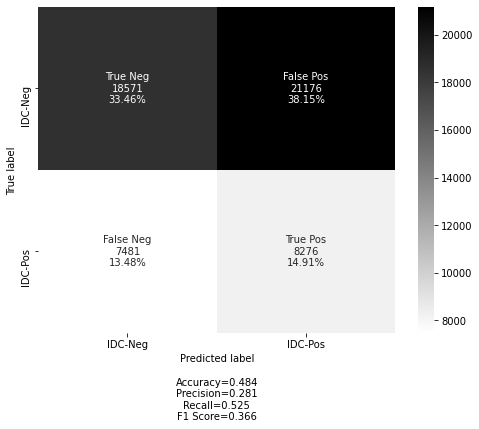

In [157]:
cf_matrix = confusion_matrix(y_labels,y_predicts)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['IDC-Neg', 'IDC-Pos']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary',
                      figsize=(8,6))

#### The Accuracy is lower than indicated in the modeling. The above metrics seem correct as the data has a large imballance in favor of IDC-negative. A model that would give a negative prediction would be correct about 66% of the time.